In [1]:

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


In [ ]:
# ==========================================
# 1. SETUP: Create a "Lumpy" Portfolio (Pareto)
# ==========================================
np.random.seed(42)
n_names = 50  # Small number of large borrowers (Concentrated)

# Shape=3 gives a realistic "Fat Head" (A few massive loans)

exposures = (np.random.pareto(a=3.0, size=n_names) + 1) * 10_000_000
exposures = np.sort(exposures)[::-1]  # Sort: Largest first
total_exposure = np.sum(exposures)

# Check Concentration
hhi = np.sum((exposures / total_exposure)**2)
print(f"Portfolio HHI: {hhi:.4f}")
print(
    f"Top 3 Borrowers hold {np.sum(exposures[:3])/total_exposure*100:.1f}% of total risk.")

# Setup Risk Parameters
pds = np.random.uniform(0.001, 0.01, n_names)  # Low PD (High Quality Banks)
lgd = 0.45
rho = 0.20
thresholds = stats.norm.ppf(pds)



Portfolio HHI: 0.0228
Top 3 Borrowers hold 12.9% of total risk.


In [4]:
from scipy.optimize import root_scalar

In [5]:
# 1. Define the target (VaR a priori)
target_loss = 30_000_000

# 2. Define the objective function
# "Find the Z value where the Smooth Portfolio Loss equals $30M"


def z_optimization_func(z_val):
    # Calculate Conditional PDs at this Z
    cond_pds = stats.norm.cdf(
        (thresholds - np.sqrt(rho)*z_val) / np.sqrt(1-rho))
    # Calculate Expected Loss (Smooth)
    expected_loss = np.sum(cond_pds * exposures * lgd)
    return expected_loss - target_loss


# 3. Solve for optimal Mu
try:
    sol = root_scalar(z_optimization_func, bracket=[0, -5], method='brentq')
    optimal_mu = sol.root
    print(f"Optimal Shift (mu) for this portfolio: {optimal_mu:.4f}")
except:
    print("Optimization failed (Target might be unreachable with Smooth model)")
    optimal_mu = -3.5  # Fallback

Optimal Shift (mu) for this portfolio: -3.0757


In [ ]:


# ==========================================
# 2. LEVEL 2 SIMULATION (Exponential Twisting)
# ==========================================
n_sims = 20000
losses_lumpy = []
weights_lumpy = []
losses_smooth = []
weights_smooth = []

# IS Parameters
shift_mu = optimal_mu      # Macro Stress (Level 1)

theta = 1.5  # the twist Strength


# Pre-generate Macro Factors (Shifted)
z_shifted = np.random.normal(shift_mu, 1, n_sims)

for z in z_shifted:

    # A. Macro Weight (Level 1)
    w_z = np.exp(-shift_mu * z + 0.5 * shift_mu**2)

    # B. Calculate Real Conditional PDs (p)
    cond_pd_real = stats.norm.cdf((thresholds - np.sqrt(rho)*z)/np.sqrt(1-rho))

    # C. Exponential Twisting

    # Formula: q = (p * exp(theta)) / (1 + p * (exp(theta) - 1))
    exp_theta = np.exp(theta)
    numerator = cond_pd_real * exp_theta
    denominator = 1 + cond_pd_real * (exp_theta - 1)

    cond_pd_twisted = numerator / denominator
    w_if_default = cond_pd_real / cond_pd_twisted
    w_if_survive = (1 - cond_pd_real) / (1 - cond_pd_twisted)

    
    # D. SIMULATE DISCRETE DEFAULTS (Level 2 - Lumpy)
    u_vec = np.random.rand(n_names)
    defaults = (u_vec < cond_pd_twisted).astype(int)
    loss_lumpy = np.sum(defaults * exposures * lgd)  # Discrete Outcome

    weights_vector = defaults * w_if_default + (1 - defaults) * w_if_survive

    # Product of all individual weights (Sum of logs for stability)
    log_w_idiosyncratic = np.sum(np.log(weights_vector))
    w_eps = np.exp(log_w_idiosyncratic)

    # --- CALCULATE Level 1 LOSS ---
    loss_smooth = np.sum(cond_pd_real * exposures * lgd)

    # Append both
    losses_lumpy.append(loss_lumpy)
    losses_smooth.append(loss_smooth)

    # Weights are identical for Level 1 analysis (only depends on Z)
    weights_lumpy.append(w_z * w_eps)
    weights_smooth.append(w_z)  # Level 1 only needs the Z-weight


# ==========================================
# 3. RISK METRICS
# ==========================================
losses_lumpy = np.array(losses_lumpy)
weights_lumpy = np.array(weights_lumpy)

# Calculate 99.9% VaR (Weighted)


def get_weighted_quantile(data, weights, quantile):
    data = np.array(data)
    weights = np.array(weights)

    idx = np.argsort(data)

    sorted_data = data[idx]
    sorted_w = weights[idx] / np.sum(weights)

    cum_w = np.cumsum(sorted_w)
    cutoff = np.searchsorted(cum_w, quantile)

    # Safety check if cutoff hits the very end
    if cutoff >= len(sorted_data):
        cutoff = len(sorted_data) - 1

    return sorted_data[cutoff]


# 1. Calculate the Smooth VaR using the same function
var_999_smooth = get_weighted_quantile(losses_smooth, weights_smooth, 0.999)
var_999_lumpy = get_weighted_quantile(losses_lumpy, weights_lumpy, 0.999)

granularity_addon = var_999_lumpy - var_999_smooth

print(f"--- COMPARISON (99.9% Confidence) ---")
print(f"Smooth VaR (Level 1): ${var_999_smooth:,.0f}")
print(f"Lumpy VaR  (Level 2): ${var_999_lumpy:,.0f}")
print(f"Concentration Add-on: ${granularity_addon:,.0f}")

--- COMPARISON (99.9% Confidence) ---
Smooth VaR (Level 1): $32,431,428
Lumpy VaR  (Level 2): $43,827,802
Concentration Add-on: $11,396,374


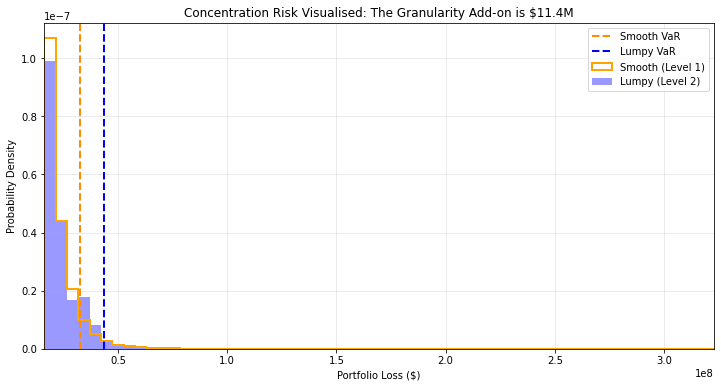

In [ ]:
# 2. Plotting: Focus on the Tail
plt.figure(figsize=(12, 6))

# Define "Tail Focus" area: Start plotting from the 99% quantile
# This hides the 99% of "boring" small losses so we can see the heavy tail detail
tail_start = get_weighted_quantile(losses_smooth, weights_smooth, 0.99)
tail_end = np.max(losses_lumpy) * 1.05  # Add 5% buffer

bins = np.linspace(tail_start, tail_end, 60)

# Plot Smooth (Level 1) - Use 'step' type to make it look like a theoretical curve
plt.hist(losses_smooth, weights=weights_smooth, bins=bins, density=True,
         histtype='step', linewidth=2, color='orange', label='Smooth (Level 1)')

# Plot Lumpy (Level 2) - Use 'bar' type to show the "jags"
plt.hist(losses_lumpy, weights=weights_lumpy, bins=bins, density=True,
         alpha=0.4, color='blue', label='Lumpy (Level 2)')


plt.axvline(var_999_smooth, color='darkorange',
            linestyle='--', linewidth=2, label='Smooth VaR')
plt.axvline(var_999_lumpy, color='blue', linestyle='--',
            linewidth=2, label='Lumpy VaR')


plt.xlim(left=tail_start, right=tail_end)
plt.xlabel("Portfolio Loss ($)")
plt.ylabel("Probability Density")
plt.title("Concentration Risk Visualised")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
def get_weighted_cvar(data, weights, var_value):
    data = np.array(data)
    weights = np.array(weights)
    # Filter for tail events only
    mask = data >= var_value
    tail_losses = data[mask]
    tail_weights = weights[mask]
    # Weighted Average
    return np.sum(tail_losses * tail_weights) / np.sum(tail_weights)


cvar_smooth = get_weighted_cvar(losses_smooth, weights_smooth, var_999_smooth)
cvar_lumpy = get_weighted_cvar(losses_lumpy, weights_lumpy, var_999_lumpy)
print(f"--- COMPARISON (99.9% Confidence) ---")
print(f"Smooth CVaR (Level 1): ${cvar_smooth:,.0f}")
print(f"Lumpy CVaR  (Level 2): ${cvar_lumpy:,.0f}")

--- COMPARISON (99.9% Confidence) ---
Smooth CVaR (Level 1): $41,201,547
Lumpy CVaR  (Level 2): $53,131,792
